In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Loopy Belief Propagation for Phase Unwrapping Time of Flight Cameras

Structure of PGM:
- nodes (discrete variables representing -1,0,1 for the phase jumps)
- factors (connecting variables together)
    - represent zero-curl constraints

Details:
- jump nodes from pixel (x,y) to (x,y+1) is represented as $s_y(x,y)$
- jump nodes from pixel (x,y) to (x+1,y) is represented as $s_x(s,y)$

- $s_x(x,y) = -1$ means that phase jump goes from (x+1,y) to (x,y)
- $s_x(x,y) = 1$ means that phase jump goes from (x,y) to (x+1,y)

probability distribution:
- $P(s_{x,y}(x,y) = i | \Phi) \propto f_d(x,y,i)$

$f_d$ represents discontinuity of depth measurements.

for x
- $f_d(x,y,i) = exp\{ -\frac{(\phi(x+1,y) - \phi(x,y) - i)^2}{2\sigma^2} \}$

for y
- $f_d(x,y,i) = exp\{ -\frac{(\phi(x,y+1) - \phi(x,y) - i)^2}{2\sigma^2} \}$

in here, $\phi(x,y)$ is the phase wrapped value (0->1)

Zero-Curl Constraint (factor)
- $s_x(x,y) + s_y(x+1,y) - s_x(x,y+1) - s_y(x,y) = 0$
- if the above is satisfied, we stop

Implementation Notes:
- we will use CS-274B implementation of LBP

In [10]:
#274b library
from factor_utils import *

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import cv2
sys.path.append("/home/andang/workspace/CV_Lab/Hololens-Project/hl2ss/viewer")

import json
import hl2ss
import hl2ss_3dcv

## Loading Data

In [18]:
CALIB_PATH = '/home/andang/workspace/CV_Lab/Hololens-Project/datasets/'
def get_all_calibration():
    calib_pv = hl2ss_3dcv._load_calibration_pv(CALIB_PATH+'calibrations/personal_video')
    calib_lt = hl2ss_3dcv._load_calibration_rm_depth_longthrow(CALIB_PATH+'calibrations/rm_depth_longthrow')
    calib_ahat = hl2ss_3dcv._load_calibration_rm_depth_ahat(CALIB_PATH+'calibrations/rm_depth_ahat')
    calib_rf = hl2ss_3dcv._load_calibration_rm_vlc(CALIB_PATH+'calibrations/rm_vlc_rightfront')
    calib_lf = hl2ss_3dcv._load_calibration_rm_vlc(CALIB_PATH+'calibrations/rm_vlc_leftfront')
    calib_rr = hl2ss_3dcv._load_calibration_rm_vlc(CALIB_PATH+'calibrations/rm_vlc_rightright')
    calib_lr = hl2ss_3dcv._load_calibration_rm_vlc(CALIB_PATH+'calibrations/rm_vlc_leftleft')
    
    uv2xy = hl2ss_3dcv.compute_uv2xy(calib_ahat.intrinsics, hl2ss.Parameters_RM_DEPTH_AHAT.WIDTH, hl2ss.Parameters_RM_DEPTH_AHAT.HEIGHT)
    # xy1, scale = hl2ss_3dcv.rm_depth_compute_rays(uv2xy, calib_ahat.scale)
    
    #return all calibrations + xy1 + scale
    return calib_pv, calib_ahat, calib_lt, calib_lf, calib_rf, calib_lr, calib_rr


def rm_depth_undistort(depth, undistort_map):
    return cv2.remap(depth, undistort_map[:, :, 0], undistort_map[:, :, 1], cv2.INTER_NEAREST)

In [19]:
calib_pv, calib_ahat, calib_lt, calib_lf, calib_rf, calib_lr, calib_rr = get_all_calibration()

In [20]:
class DataLoader:
    def __init__(self, path):
        self.PATH = path
        with open(self.PATH+'vlc1_pose.json') as f: # vlc LF
            self.j_vlc_lf = json.load(f)
        with open(self.PATH+'vlc3_pose.json') as f:
            self.j_vlc_rf = json.load(f)
        with open(self.PATH+'depth_ahat_pose.json') as f: # long throw
            self.j_ahat = json.load(f)
        with open(self.PATH+'pv_pose.json') as f: # long throw
            self.j_pv = json.load(f)
        with open(self.PATH+'vlc2_pose.json') as f: # long throw
            self.j_vlc_ll = json.load(f)
        with open(self.PATH+'vlc4_pose.json') as f: # long throw
            self.j_vlc_rr = json.load(f)
            
        self.tstamps = sorted(self.j_pv.keys())
        
    def get_posed_data(self, idx, sensor_name):

        if type(idx) is str:
            tstamp_name = idx
        else:
            tstamp_name = self.tstamps[idx]
        im = cv2.imread(self.PATH+sensor_name+'/'+tstamp_name+'.png')
        
        if sensor_name == 'vlc_lf':
            pose = self.j_vlc_lf[tstamp_name]
        elif sensor_name == 'vlc_rf':
            pose = self.j_vlc_rf[tstamp_name]
            
        elif sensor_name == 'pv':
            pose = self.j_pv[tstamp_name]
        elif sensor_name == 'depth_ahat':
            pose = self.j_ahat[tstamp_name]
            
        elif sensor_name == 'vlc_ll':
            pose = self.j_vlc_ll[tstamp_name]
        elif sensor_name == 'vlc_rr':
            pose = self.j_vlc_rr[tstamp_name]
        else:
            pose = []
        return im, np.array(pose)

In [21]:
PATH = '/home/andang/workspace/CV_Lab/Hololens-Project/datasets/uav_place/vid2/'
dataload = DataLoader(PATH)

In [22]:
im_ahat, pose = dataload.get_posed_data(3500,'depth_ahat')

im_ahat = rm_depth_undistort(im_ahat,calib_ahat.undistort_map)

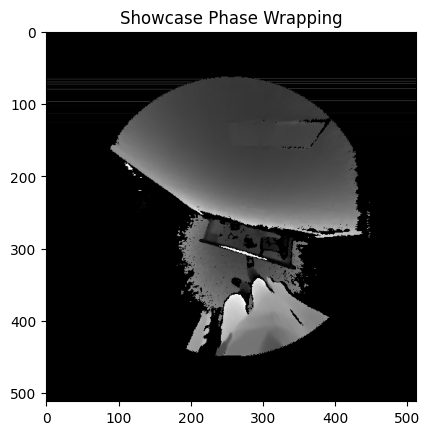

In [23]:
plt.imshow(im_ahat)
plt.title('Showcase Phase Wrapping')
plt.show()

## Testing LBP

In [24]:
G = make_debug_graph()

In [25]:
nodeMargs = run_loopy_bp_parallel(G,100,1e-2)
print(nodeMargs[-1])

Parallel LBP converged in 2 iterations.
{'x4': array([[0.4],
       [0.6]]), 'x3': array([[0.5],
       [0.5]]), 'x2': array([[0.345],
       [0.38 ],
       [0.275]]), 'x1': array([[0.4935],
       [0.5065]])}


## Creating Graph from Phase Unwrapping LBP Paper

In [26]:
def create_phase_unwrap_graph(im_ahat, depth_var):
    '''
        Parameters:
        ============
        :im_ahat (H,W) depth phase wrapped image grayscaled and scaled from [0,1) dtype=float
        :depth_var (scalar) value representing a user-specified parameter of the depth variance between pixel
        
        Returns:
        ========
        -> Probabilistic Graphical Model of the phase wrapping problem.
        
    '''
    
    h,w = im_ahat.shape[:2]
    
    '''
        Creating Jump Nodes
        ===================
        
            Example:
            ========
            (0,2)  --- sx(0,2) --- (1,2)
              |           |          |
            sy(0,1) ---  curl  --- sy(1,1)
              |           |          |
            (0,1)  --- sx(0,1) --- (1,1)
              |           |          |
            sy(0,0) ---  curl  --- sy(1,0)
              |           |          |
            (0,0)  --- sx(0,0) --- (1,0)
            
            # y jump nodes = H-1
            # x jump nodes = W-1
    '''
    
    G = SimpleFactorGraph()
    
    #create list of nodes
    #each node is a variable of 3 states (-1,0,1)
    
    print('Adding nodes...')
    node_list = []
    for i in range(h):
        for j in range(w):
            if j < w-1:
                node_list.append(f'Sx({j},{i})') #S_x(x,y)
            if i < h-1:
                node_list.append(f'Sy({j},{i})') #S_y(x,y)
    
    G.add_nodes_from(node_list)
    
    edges_list = []
    factors_list = []
    
    # add unary evidence factors that take into account the depth
    print('Adding unary evidence factors...')
    for i in range(h):
        for j in range(w):
            if j < w-1:
                #f_d for s_x
                factor_array_X = np.arange(-1,2,dtype=np.float32)
                factor_array_X = np.exp(-1*((im_ahat[i,j+1] - im_ahat[i,j] - factor_array_X)**2)/(2*depth_var))
                phi_x = FastDiscreteFactor([f'Sx({j},{i})'], [3], factor_array_X)
                
                factors_list.append(phi_x)
                edges_list.append((f'Sx({j},{i})',phi_x))
                
            if i < h-1:
                factor_array_Y = np.arange(-1,2,dtype=np.float32)
                factor_array_Y = np.exp(-1*((im_ahat[i+1,j] - im_ahat[i,j] - factor_array_Y)**2)/(2*depth_var))
                phi_y = FastDiscreteFactor([f'Sy({j},{i})'], [3], factor_array_Y)
                
                factors_list.append(phi_y)
                edges_list.append((f'Sy({j},{i})',phi_y))
    G.add_factors(*factors_list)
    G.add_edges_from(edges_list)



    # add unary evidence factors that take into account the depth
    # print('Adding unary evidence factors...')
#     test = np.ones((512,512),dtype=np.float32)
#     factorStack = np.dstack((test*-1,test*0,test*1))
    
#     X_array = np.exp(-1*(( (im_ahat[:,1:] - im_ahat[:,:-1])[:,:,np.newaxis] - factorStack[:,:-1])**2)/(2*depth_var))
#     Y_array = np.exp(-1*(( (im_ahat[1:,:] - im_ahat[:-1,:])[:,:,np.newaxis] - factorStack[:-1,:])**2)/(2*depth_var))
    
#     for i in range(h):
#         for j in range(w):
#             if j < w-1:
#                 factor_array_X = X_array[i,j,:]
#                 phi_x = FastDiscreteFactor([f'Sx({j},{i})'], [3], factor_array_X)
                
#                 factors_list.append(phi_x)
#                 edges_list.append((f'Sx({j},{i})',phi_x))
#             if i < h-1:
#                 factor_array_Y = Y_array[i,j,:]
#                 phi_y = FastDiscreteFactor([f'Sy({j},{i})'], [3], factor_array_Y)
                
#                 factors_list.append(phi_y)
#                 edges_list.append((f'Sy({j},{i})',phi_y))
#     G.add_factors(*factors_list)
#     G.add_edges_from(edges_list)
    
    
    
    # add boundary factors to represent the zero-curl node constraint
    print('Adding curl constraint factors...')
    
    boundary_factors = []
    boundary_edges = []
    for i in range(h-1):
        for j in range(w-1):
            #zero curl constraint equation = s_x(x,y) + s_y(x+1,y) - s_x(x,y+1) - s_y(x,y) = 0
            #it has 4 boundary jump nodes, so factor array is 3x3x3x3
            
            #create constraint matrix
            mat = np.arange(-1,2)
            
            sy1 = np.arange(-1,2)
            mat = mat.reshape(*mat.shape,1) + sy1.reshape(1,*sy1.shape)
            
            sx1 = np.arange(-1,2)
            mat = mat.reshape(*mat.shape,1) - sx1.reshape(1,*sx1.shape)
            
            sy = np.arange(-1,2)
            mat = mat.reshape(*mat.shape,1) - sy.reshape(1,*sy.shape)
            
            mask = (mat == 0) #all that are good with zero curl constraint
            
            mat[~mask] = 0
            mat[mask] = 1
            
            factor_node_list = [f'Sx({j},{i})', f'Sy({j+1},{i})', f'Sx({j},{i+1})', f'Sy({j},{i})']
            
            boundary_phi = FastDiscreteFactor(factor_node_list, [3,3,3,3], mat)
            
            boundary_factors.append(boundary_phi)
            boundary_edges.extend([(fn,boundary_phi) for fn in factor_node_list])
            
    G.add_factors(*boundary_factors)
    G.add_edges_from(boundary_edges)
    
    return G
    

In [27]:
G = create_phase_unwrap_graph(im_ahat.mean(axis=2)/255,0.75)

Adding nodes...
Adding unary evidence factors...
Adding curl constraint factors...


In [ ]:
nodeMargs = run_loopy_bp_parallel2(G,20,1e-5)

In [ ]:
def fix_ahat(nodeMarg, im_ahat):
    h,w = im_ahat.shape[:2]
    
    depth_int = np.zeros((h,w),dtype=np.float32)
    
    states = [-1,0,1]
    for i in range(h):
        for j in range(w):
            if j < w-1:
                state = states[nodeMarg[f'Sx({j},{i})'].argmax()]
                depth_int[i,j+1:] += state
                
            if i < h-1:
                state = states[nodeMarg[f'Sy({j},{i})'].argmax()]
                depth_int[i+1:,j] += state
                
    return depth_int + im_ahat

In [ ]:
fixed_depth = fix_ahat(nodeMargs,im_ahat.mean(axis=2)/255)

In [ ]:
plt.imshow(fixed_depth,cmap='gray')

In [ ]:
plt.imshow(im_ahat.mean(axis=2)/255,cmap='gray')

In [ ]:
plt.hist(fixed_depth.flatten()+4)

In [ ]:
plt.hist(im_ahat.mean(axis=2).flatten())